## Imports

In [1]:
# !conda activate n2v
%load_ext autoreload

import numpy as np
from matplotlib import pyplot as plt
import zarr
import os

import gunpowder as gp
# import logging
# logging.basicConfig(level=logging.INFO)

# from this repo
# from segway.tasks.make_zarr_from_tiff import task_make_zarr_from_tiff_volume as tif2zarr
from boilerPlate import GaussBlur, Noiser

2021-08-24 08:49:06.473698: I tensorflow/stream_executor/platform/default/dso_loader.cc:53] Successfully opened dynamic library libcudart.so.11.0


In [2]:
# ADD HELPER FUNCTIONS

def noise_pipe(src, target, pipeline, noise_order, noise_dict):
    this_array = src
    for noise in noise_order:
        if noise_dict[noise]:
            if noise =='downX' and noise_dict[noise]:
                pipeline += gp.DownSample(src, (1, noise_dict[noise], noise_dict[noise]), target) # assumes zyx coordinates (and non-isometric)
                this_array = target
            elif noise =='gaussBlur' and noise_dict[noise]:
                pipeline += GaussBlur(this_array, noise_dict[noise])
            elif noise =='gaussNoise' and noise_dict[noise]:
                pipeline += gp.NoiseAugment(this_array, mode='gaussian', var=noise_dict[noise])
            elif noise =='poissNoise' and noise_dict[noise]:
                pipeline += gp.NoiseAugment(this_array, mode='poisson')
            # elif noise =='deform' and noise_dict[noise]: # TODO: IMPLEMENT
            #     pipeline += ...

    return pipeline

In [3]:
# ADD HELPER FUNCTIONS

def bring_the_noise(src, pipeline, noise_order, noise_dict, noise_version=''):
    this_array = src
    noise_name = ''
    arrays = [src]
    for noise in noise_order:
        if noise_dict[noise]:
            if str(noise_dict[noise]).isnumeric():
                noise_name += noise + str(noise_dict[noise])
            elif isinstance(noise_dict[noise], bool):
                noise_name += noise

            new_array = gp.ArrayKey(noise_name.upper())
            
            if noise =='downX' and noise_dict[noise]:
                pipeline += gp.DownSample(this_array, (1, noise_dict[noise], noise_dict[noise]), new_array) # assumes zyx coordinates (and non-isometric)
            elif noise =='gaussBlur' and noise_dict[noise]:
                pipeline += GaussBlur(this_array, noise_dict[noise], new_array=new_array)
            elif noise =='gaussNoise' and noise_dict[noise]:
                pipeline += Noiser(this_array, new_array=new_array, mode='gaussian', var=noise_dict[noise])
            elif noise =='poissNoise' and noise_dict[noise]:
                pipeline += Noiser(this_array, new_array=new_array, mode='poisson')
            # elif noise =='deform' and noise_dict[noise]: # TODO: IMPLEMENT
            #     pipeline += ...
            
            noise_name += '_'
            this_array = new_array
            arrays.append(new_array)
    
    if noise_version == '':
        noise_name = noise_name[:-1]
    else:
        noise_name += noise_version
    return pipeline, arrays, noise_name

# Specify Parameters (source, noise type, downsampling, etc.)

In [40]:
noise_version = '' # for making multiple independently generated noise versions (e.g. for Fourier Shell analysis)
src_path = '/n/groups/htem/ESRF_id16a/tomo_ML/synapse/cb2/volumes/' # PATH FOR ZARR

raw_name = 'raw'
noise_dict = {'downX': 8, # cudegy mimic of 30nm pixel size (max uttained) from sensor at ESRF.i16a X-ray source, assuming 4nm voxel size EM source images
         'gaussBlur': 30, # cudegy mimic of 30nm resolution of KB mirrors at ESRF.i16a X-ray source
         'gaussNoise': None, # ASSUMES MEAN = 0, THIS SETS VARIANCE
         'poissNoise': True, # cudegy mimic of sensor shot noise (hot pixels) at ESRF.i16a X-ray source
        #  'deform': , # TODO: IMPLEMENT
         }

noise_order = [
                'gaussBlur', 
               'downX', 
               'gaussNoise', 
               'poissNoise'
               ]

# noise_order = ['downX', 
#                'gaussBlur', 
#                'gaussNoise', 
#                'poissNoise'
#                ]

samples = [
    'ml0', # should be already done
    'ml1',
    'cutout1',
    'cutout2',
    'cutout5',
    'cutout6',
    'cutout7',
    ]

src_voxel_size = (40, 4, 4)

In [41]:
##### BELOW IS AUTOMATIC PARAMETER SETUP BASED ON ABOVE SPECIFICATIONS ######

noise_name = ''
for noise in noise_order:
    if noise_dict[noise]:
        if str(noise_dict[noise]).isnumeric():
            noise_name += noise + str(noise_dict[noise]) + '_'
        elif isinstance(noise_dict[noise], bool):
            noise_name += noise + '_'

if noise_version == '':
    noise_name = noise_name[:-1]
else:
    noise_name += noise_version

print('Layer name for noised data: ' + noise_name)

if noise_dict['downX']:
    dest_voxel_size = [src_voxel_size[s] * noise_dict['downX'] if s > 0 else src_voxel_size[s] for s in range(len(src_voxel_size))]
else:
    dest_voxel_size = src_voxel_size
src_voxel_size = gp.Coordinate(src_voxel_size)
dest_voxel_size = gp.Coordinate(dest_voxel_size)


Layer name for noised data: gaussBlur30_downX8_poissNoise


# Check out raw data

In [9]:
sample = samples[0]
src = f'{src_path}{sample}/{sample}.zarr/volumes'
data = zarr.open(src)

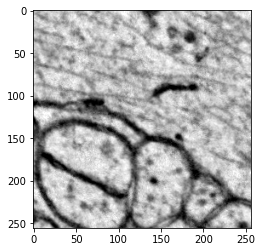

In [10]:
#pick indices/window
window = 256
x_off = 100
y_off = 100
z_off = 10
plt.imshow(data['raw'][z_off, y_off:y_off+window, x_off:x_off+window], cmap='gray')

# Setup Noising Pipeline

In [127]:
%autoreload
from boilerPlate import GaussBlur, Noiser

### Test pipeline before saving:

In [42]:
#pick a sample
sample = samples[0]

# declare arrays to use in the pipeline
raw = gp.ArrayKey('RAW') # raw data
raw_spec = gp.ArraySpec(voxel_size=src_voxel_size, interpolatable=True)

src = f'{src_path}{sample}/{sample}.zarr/volumes'
zarr.open(src)
source = gp.ZarrSource(    # add the data source
        src,  # the zarr container
        {raw: raw_name},  # which dataset to associate to the array key
        {raw: raw_spec}  # meta-information
)

# add normalization
normalize = gp.Normalize(raw)

# add a RandomLocation node to the pipeline to randomly select a sample
random_location = gp.RandomLocation()

proto_pipe = source + normalize + random_location

pipeline, arrays, noise_name = bring_the_noise(raw, proto_pipe, noise_order, noise_dict)

noisy = arrays[-1] # data noise added

# request matching the model input and output sizes
request = gp.BatchRequest()
for array in arrays:
        request.add(array, (40, 2048, 2048))

with gp.build(pipeline):
        batch = pipeline.request_batch(request)

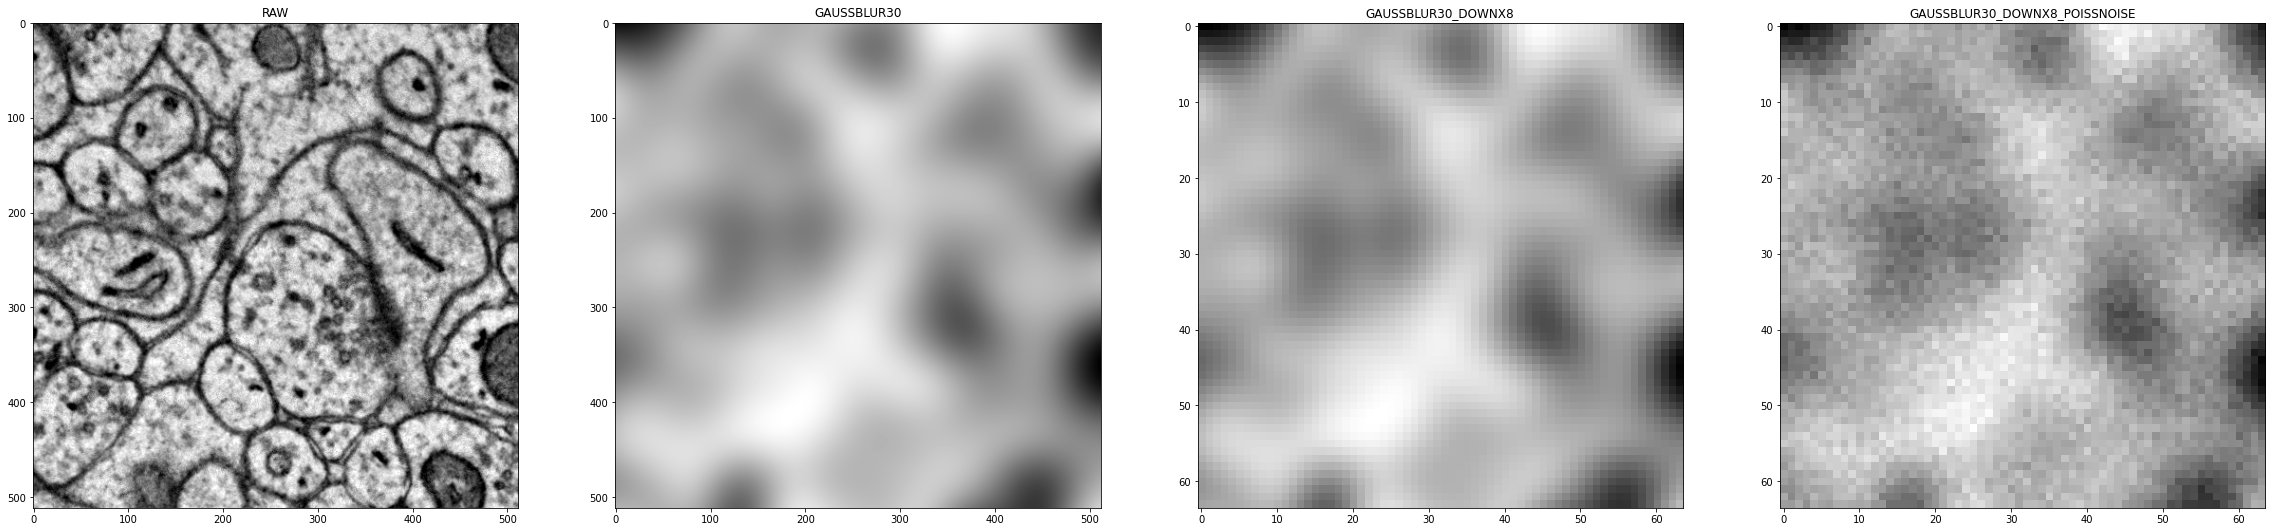

In [43]:
fig, axs = plt.subplots(1,len(arrays), figsize=(40, 40*len(arrays)))
for i, array in enumerate(arrays):
    axs[i].imshow(batch[array].data.squeeze(), cmap='gray')
    axs[i].set_title(array.identifier)

### Run actual

In [15]:
# assemble and run pipeline for each dataset
for sample in samples:
        # declare arrays to use in the pipeline
        raw = gp.ArrayKey('RAW') # raw data
        raw_spec = gp.ArraySpec(voxel_size=src_voxel_size, interpolatable=True)

        src = f'{src_path}{sample}/{sample}.zarr/volumes'
        zarr.open(src)
        source = gp.ZarrSource(    # add the data source
                src,  # the zarr container
                {raw: raw_name},  # which dataset to associate to the array key
                {raw: raw_spec}  # meta-information
        )

        # add normalization
        normalize = gp.Normalize(raw)

        proto_pipe = source + normalize

        pipeline, arrays, noise_name = bring_the_noise(raw, proto_pipe, noise_order, noise_dict)

        noisy = arrays[-1] # data noise added
        
        stack = gp.Stack(8)

        # request matching the model input and output sizes
        scan_request = gp.BatchRequest()
        for array in arrays:
                scan_request.add(array, (40, 512, 512))

        scan = gp.Scan(scan_request, num_workers=os.cpu_count())

        # request an empty batch from scan
        request = gp.BatchRequest()

        # setup Cache
        cache = gp.PreCache()

        # get performance stats
        performance = gp.PrintProfilingStats(every=250)

        destination = gp.ZarrWrite(
                dataset_names = {noisy: noise_name},
                output_dir = f'{src_path}{sample}',
                output_filename = f'{sample}.zarr/volumes',
                #dataset_dtypes = {noisy: np.uint8} # save as 0-255 values (should match raw)
        )

        pipeline += (cache +
                stack + 
                destination + 
                scan + 
                performance)
        
        with gp.build(pipeline):
                print(f'Starting {src}...')
                pipeline.request_batch(request)
                print(f'Brought the noise to {src}')

Starting /n/groups/htem/ESRF_id16a/tomo_ML/synapse/cb2/volumes/ml0/ml0.zarr/volumes...


## Depracated

In [ ]:
# assemble pipeline for each volume and run
for sample in samples:    
        # declare arrays to use in the pipeline
        raw = gp.ArrayKey('RAW') # raw data
        noisy = gp.ArrayKey('NOISY') # data noise added
        raw_spec = gp.ArraySpec(voxel_size=src_voxel_size, interpolatable=True)

        stack = gp.Stack(8)

        # request matching the model input and output sizes
        scan_request = gp.BatchRequest()
        scan_request.add(raw, (40, 256, 256))#, src_voxel_size)
        scan_request.add(noisy, (40, 256, 256))#, dest_voxel_size)

        scan = gp.Scan(scan_request, num_workers=os.cpu_count())

        # request an empty batch from scan
        request = gp.BatchRequest()

        # setup Cache
        cache = gp.PreCache()

        # get performance stats
        performance = gp.PrintProfilingStats(every=100)
        # $src_path$volume/$volume.zarr/volumes/$layer
        src = f'{src_path}{sample}/{sample}.zarr/volumes'
        zarr.open(src)
        source = gp.ZarrSource(    # add the data source
                src,  # the zarr container
                {raw: raw_name},  # which dataset to associate to the array key
                {raw: raw_spec}  # meta-information
        )

        destination = gp.ZarrWrite(
                dataset_names = {noisy: noise_name},
                output_dir = f'{src_path}{sample}',
                output_filename = f'{sample}.zarr/volumes',
                #dataset_dtypes = {noisy: np.uint8} # save as 0-255 values (should match raw)
        )

        # add normalization
        normalize = gp.Normalize(raw)

        proto_pipe = source + normalize

        pipeline = (noise_pipe(raw, noisy, proto_pipe, noise_order, noise_dict) + 
                        cache +
                        stack + 
                        destination + 
                        scan + 
                        performance)
        
        with gp.build(pipeline):
                pipeline.request_batch(request)
                print('Finished: ' + src)

In [19]:
test = zarr.open('/n/groups/htem/ESRF_id16a/tomo_ML/synapse/cb2/volumes/cutout1/cutout1.zarr/volumes')
noised = test[noise_name]
test.info

Name,/
Type,zarr.hierarchy.Group
Read-only,False
Store type,zarr.storage.DirectoryStore
No. members,3
No. arrays,2
No. groups,1
Arrays,"gaussBlur30_downX8_poissNoise, raw"
Groups,labels


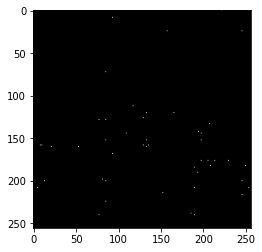

In [20]:
plt.imshow(noised[0,:,:], cmap='gray', vmin=np.min(noised), vmax=np.max(noised))

In [15]:
np.max(noised)

1